In [1]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
from torchmodel import UNet
from root_dataset import Train_dataset, Test_dataset
import albumentations as albu
import segmentation_models_pytorch as smp
import random
import numpy as np
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)


c:\Users\neden\miniconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
def get_train_augmentation(height):
    trainaugmentation = albu.Compose([
        albu.Resize(height,height),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomRotate90(p=0.5),
        albu.Transpose(p=0.5),
        albu.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=15, p=0.5),
        albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        albu.GridDistortion(p=0.5),
        albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        albu.RandomBrightnessContrast(p=0.5),
        albu.RandomGamma(p=0.5),
        albu.GaussianBlur(blur_limit=(3, 7), p=0.5),
        albu.GaussNoise(),
        albu.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5), 
        #albu.Lambda(image=lambda x,**kwargs: x/255),
    ])
    return trainaugmentation

In [4]:
def get_val_augmentation(height):
    trainaugmentation = albu.Compose([
        albu.Resize(height,height),
        # albu.Lambda(image=lambda x,**kwargs: x/255),
    ])
    return trainaugmentation

In [5]:
train_aug = get_train_augmentation(512)
val_aug = get_val_augmentation(512)

In [6]:
train = Train_dataset(train_aug,'crosval/train','castom-masks/masks_machine',device)
val = Train_dataset(val_aug,'crosval/val','castom-masks/masks_machine',device)

['AAE_0014.png', 'AAE_0016.png', 'AAE_0017.png', 'AAE_0019.png', 'AAE_0021.png', 'AAE_0022.png', 'AAE_0025.png', 'AAE_0027.png', 'AAE_0028.png', 'AAE_0036.png', 'AAE_0037.png', 'AAE_0040.png', 'AAE_0041.png', 'AAE_0045.png', 'AAE_0047.png', 'AAE_0048.png', 'AAE_0057.png', 'AAE_0058.png', 'AAE_0062.png', 'AAE_0063.png', 'AAE_0068.png', 'AAE_0070.png', 'AAE_0071.png', 'AAE_0073.png', 'AAE_0076.png', 'AAE_0080.png', 'AAE_0083.png', 'AAE_0085.png', 'AAE_0087.png', 'AAE_0089.png', 'AAE_0097.png', 'AAE_0098.png', 'AAE_0100.png', 'AAE_0101.png', 'AAE_0107.png', 'AAE_0114.png', 'AAE_0116.png', 'AAE_0117.png', 'AAE_0119.png', 'AAE_0124.png', 'AAE_0125.png', 'AAE_0127.png', 'AAE_0136.png', 'AAE_0140.png', 'AAE_0144.png', 'AAE_0145.png', 'AAE_0146.png', 'AAE_0147.png', 'AAE_0150.png', 'AAE_0154.png', 'AAE_0156.png', 'AAE_0158.png', 'AAE_0161.png', 'AAE_0165.png', 'AAE_0167.png', 'AAE_0170.png', 'AAE_0173.png', 'AAE_0174.png', 'AAE_0176.png', 'AAE_0177.png', 'AAE_0179.png', 'AAE_0180.png', 'AAE_01

<Figure size 640x480 with 0 Axes>

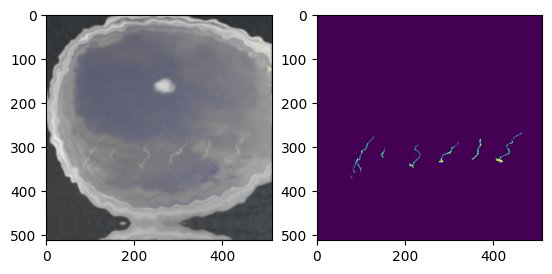

In [7]:
plt.figure()
f, axarr = plt.subplots(1,2) 
image,mask = train.__getitem__(0)
axarr[0].imshow(image.permute(1,2,0).cpu())
axarr[1].imshow(mask.permute(1,2,0).cpu())

In [8]:
model = UNet(3,1)

In [9]:
train_loader = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=4, shuffle=False)

In [10]:
focal_loss = smp.losses.FocalLoss('binary')
iou_loss = smp.losses.JaccardLoss('binary')
dice_loss = smp.losses.DiceLoss('binary')
bce_loss = smp.losses.SoftBCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),0.001,amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=5,verbose=True)

In [11]:
def loss_f(outputs, targets):
    return focal_loss(outputs, targets) * 0.2 + iou_loss(outputs, targets) * 0.2 + dice_loss(outputs, targets) * 0.4 + bce_loss(outputs,targets) * 0.2

In [12]:
def metric(outputs, targets):
    return 1 - dice_loss(outputs, targets)

In [30]:
epochs = 200
patience = 20
model_path =  'best-model.pt'

In [14]:
model.to(device)
best_loss = 100
counter = 0
for epoch in range(epochs):
    train_loss = 0.0
    model.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_f(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    val_loss = 0.0

    model.eval()
    for inputs, targets in tqdm(val_loader):
        model.eval()
        outputs = model(inputs)
            
            # Calculate loss
        loss = loss_f(outputs, targets)
        val_loss += loss.item()

    val_loss /= len(val_loader)

    scheduler.step(val_loss)

    improve = False

    if val_loss < best_loss: 
        best_loss = val_loss
        improve = True
        print('model saved')
        torch.save(model,model_path)

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Dice: {metric(outputs, targets):.4f} | Val Dice: {metric(outputs, targets):.4f}")

    if not improve:
        counter += 1
        if counter > patience:
            print('early stop')
            break
    else:
        counter = 0
        

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


model saved
Epoch [1/200] | Train Loss: 0.9238 | Val Loss: 0.9331 | Train Dice: 0.0329 | Val Dice: 0.0329


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [2/200] | Train Loss: 0.8861 | Val Loss: 0.9032 | Train Dice: 0.0327 | Val Dice: 0.0327


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [3/200] | Train Loss: 0.8648 | Val Loss: 0.8754 | Train Dice: 0.0324 | Val Dice: 0.0324


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


model saved
Epoch [4/200] | Train Loss: 0.8502 | Val Loss: 0.8671 | Train Dice: 0.0325 | Val Dice: 0.0325


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


model saved
Epoch [5/200] | Train Loss: 0.8395 | Val Loss: 0.8541 | Train Dice: 0.0329 | Val Dice: 0.0329


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


model saved
Epoch [6/200] | Train Loss: 0.8298 | Val Loss: 0.8329 | Train Dice: 0.0330 | Val Dice: 0.0330


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


model saved
Epoch [7/200] | Train Loss: 0.8222 | Val Loss: 0.8208 | Train Dice: 0.0330 | Val Dice: 0.0330


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


model saved
Epoch [8/200] | Train Loss: 0.8176 | Val Loss: 0.8194 | Train Dice: 0.0330 | Val Dice: 0.0330


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


model saved
Epoch [9/200] | Train Loss: 0.8119 | Val Loss: 0.8137 | Train Dice: 0.0330 | Val Dice: 0.0330


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


model saved
Epoch [10/200] | Train Loss: 0.8085 | Val Loss: 0.8085 | Train Dice: 0.0330 | Val Dice: 0.0330


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


Epoch [11/200] | Train Loss: 0.8046 | Val Loss: 0.8088 | Train Dice: 0.0331 | Val Dice: 0.0331


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


model saved
Epoch [12/200] | Train Loss: 0.8025 | Val Loss: 0.8040 | Train Dice: 0.0330 | Val Dice: 0.0330


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


model saved
Epoch [13/200] | Train Loss: 0.8004 | Val Loss: 0.8011 | Train Dice: 0.0330 | Val Dice: 0.0330


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


model saved
Epoch [14/200] | Train Loss: 0.7982 | Val Loss: 0.8002 | Train Dice: 0.0330 | Val Dice: 0.0330


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [15/200] | Train Loss: 0.7962 | Val Loss: 0.7960 | Train Dice: 0.0330 | Val Dice: 0.0330


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


model saved
Epoch [16/200] | Train Loss: 0.7949 | Val Loss: 0.7956 | Train Dice: 0.0329 | Val Dice: 0.0329


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


model saved
Epoch [17/200] | Train Loss: 0.7936 | Val Loss: 0.7924 | Train Dice: 0.0329 | Val Dice: 0.0329


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


model saved
Epoch [18/200] | Train Loss: 0.7921 | Val Loss: 0.7909 | Train Dice: 0.0329 | Val Dice: 0.0329


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


model saved
Epoch [19/200] | Train Loss: 0.7920 | Val Loss: 0.7903 | Train Dice: 0.0329 | Val Dice: 0.0329


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [20/200] | Train Loss: 0.7906 | Val Loss: 0.7892 | Train Dice: 0.0329 | Val Dice: 0.0329


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [21/200] | Train Loss: 0.7898 | Val Loss: 0.7881 | Train Dice: 0.0329 | Val Dice: 0.0329


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Epoch [22/200] | Train Loss: 0.7891 | Val Loss: 0.7885 | Train Dice: 0.0329 | Val Dice: 0.0329


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


model saved
Epoch [23/200] | Train Loss: 0.7885 | Val Loss: 0.7877 | Train Dice: 0.0329 | Val Dice: 0.0329


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


model saved
Epoch [24/200] | Train Loss: 0.7880 | Val Loss: 0.7867 | Train Dice: 0.0329 | Val Dice: 0.0329


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [25/200] | Train Loss: 0.7873 | Val Loss: 0.7867 | Train Dice: 0.0329 | Val Dice: 0.0329


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [26/200] | Train Loss: 0.7870 | Val Loss: 0.7860 | Train Dice: 0.0329 | Val Dice: 0.0329


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [27/200] | Train Loss: 0.7863 | Val Loss: 0.7855 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


model saved
Epoch [28/200] | Train Loss: 0.7861 | Val Loss: 0.7850 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


model saved
Epoch [29/200] | Train Loss: 0.7857 | Val Loss: 0.7847 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


model saved
Epoch [30/200] | Train Loss: 0.7853 | Val Loss: 0.7844 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [31/200] | Train Loss: 0.7851 | Val Loss: 0.7844 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [32/200] | Train Loss: 0.7847 | Val Loss: 0.7838 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


model saved
Epoch [33/200] | Train Loss: 0.7844 | Val Loss: 0.7835 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [34/200] | Train Loss: 0.7843 | Val Loss: 0.7832 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


model saved
Epoch [35/200] | Train Loss: 0.7842 | Val Loss: 0.7832 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


model saved
Epoch [36/200] | Train Loss: 0.7840 | Val Loss: 0.7828 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [37/200] | Train Loss: 0.7838 | Val Loss: 0.7827 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


Epoch [38/200] | Train Loss: 0.7836 | Val Loss: 0.7827 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


model saved
Epoch [39/200] | Train Loss: 0.7834 | Val Loss: 0.7825 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [40/200] | Train Loss: 0.7832 | Val Loss: 0.7823 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [41/200] | Train Loss: 0.7832 | Val Loss: 0.7822 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [42/200] | Train Loss: 0.7828 | Val Loss: 0.7820 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


model saved
Epoch [43/200] | Train Loss: 0.7831 | Val Loss: 0.7819 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [44/200] | Train Loss: 0.7830 | Val Loss: 0.7819 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


model saved
Epoch [45/200] | Train Loss: 0.7826 | Val Loss: 0.7816 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [46/200] | Train Loss: 0.7826 | Val Loss: 0.7816 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [47/200] | Train Loss: 0.7826 | Val Loss: 0.7816 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


model saved
Epoch [48/200] | Train Loss: 0.7825 | Val Loss: 0.7815 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


model saved
Epoch [49/200] | Train Loss: 0.7824 | Val Loss: 0.7814 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


model saved
Epoch [50/200] | Train Loss: 0.7821 | Val Loss: 0.7813 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [51/200] | Train Loss: 0.7821 | Val Loss: 0.7812 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Epoch [52/200] | Train Loss: 0.7822 | Val Loss: 0.7813 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [53/200] | Train Loss: 0.7821 | Val Loss: 0.7811 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [54/200] | Train Loss: 0.7820 | Val Loss: 0.7811 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


model saved
Epoch [55/200] | Train Loss: 0.7817 | Val Loss: 0.7810 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [56/200] | Train Loss: 0.7820 | Val Loss: 0.7810 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


model saved
Epoch [57/200] | Train Loss: 0.7818 | Val Loss: 0.7809 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [58/200] | Train Loss: 0.7818 | Val Loss: 0.7809 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


model saved
Epoch [59/200] | Train Loss: 0.7817 | Val Loss: 0.7808 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


model saved
Epoch [60/200] | Train Loss: 0.7818 | Val Loss: 0.7808 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Epoch [61/200] | Train Loss: 0.7816 | Val Loss: 0.7808 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


model saved
Epoch [62/200] | Train Loss: 0.7818 | Val Loss: 0.7807 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [63/200] | Train Loss: 0.7817 | Val Loss: 0.7807 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [64/200] | Train Loss: 0.7815 | Val Loss: 0.7807 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


model saved
Epoch [65/200] | Train Loss: 0.7816 | Val Loss: 0.7806 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


model saved
Epoch [66/200] | Train Loss: 0.7815 | Val Loss: 0.7806 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [67/200] | Train Loss: 0.7813 | Val Loss: 0.7806 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [68/200] | Train Loss: 0.7813 | Val Loss: 0.7805 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


model saved
Epoch [69/200] | Train Loss: 0.7815 | Val Loss: 0.7805 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


model saved
Epoch [70/200] | Train Loss: 0.7814 | Val Loss: 0.7805 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [71/200] | Train Loss: 0.7814 | Val Loss: 0.7804 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [72/200] | Train Loss: 0.7813 | Val Loss: 0.7804 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [73/200] | Train Loss: 0.7813 | Val Loss: 0.7804 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [74/200] | Train Loss: 0.7812 | Val Loss: 0.7804 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [75/200] | Train Loss: 0.7814 | Val Loss: 0.7803 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


model saved
Epoch [76/200] | Train Loss: 0.7813 | Val Loss: 0.7803 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [77/200] | Train Loss: 0.7812 | Val Loss: 0.7803 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


model saved
Epoch [78/200] | Train Loss: 0.7812 | Val Loss: 0.7803 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


model saved
Epoch [79/200] | Train Loss: 0.7811 | Val Loss: 0.7803 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [80/200] | Train Loss: 0.7811 | Val Loss: 0.7802 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [81/200] | Train Loss: 0.7811 | Val Loss: 0.7802 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Epoch [82/200] | Train Loss: 0.7811 | Val Loss: 0.7802 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [83/200] | Train Loss: 0.7810 | Val Loss: 0.7802 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


model saved
Epoch [84/200] | Train Loss: 0.7810 | Val Loss: 0.7802 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Epoch [85/200] | Train Loss: 0.7810 | Val Loss: 0.7802 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [86/200] | Train Loss: 0.7811 | Val Loss: 0.7801 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


model saved
Epoch [87/200] | Train Loss: 0.7811 | Val Loss: 0.7801 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [88/200] | Train Loss: 0.7809 | Val Loss: 0.7801 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [89/200] | Train Loss: 0.7809 | Val Loss: 0.7801 | Train Dice: 0.0329 | Val Dice: 0.0329


100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


model saved
Epoch [90/200] | Train Loss: 0.7811 | Val Loss: 0.7801 | Train Dice: 0.0329 | Val Dice: 0.0329


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [91/200] | Train Loss: 0.7809 | Val Loss: 0.7800 | Train Dice: 0.0330 | Val Dice: 0.0330


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


model saved
Epoch [92/200] | Train Loss: 0.7809 | Val Loss: 0.7800 | Train Dice: 0.0332 | Val Dice: 0.0332


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


model saved
Epoch [93/200] | Train Loss: 0.7809 | Val Loss: 0.7799 | Train Dice: 0.0335 | Val Dice: 0.0335


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [94/200] | Train Loss: 0.7808 | Val Loss: 0.7799 | Train Dice: 0.0334 | Val Dice: 0.0334


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [95/200] | Train Loss: 0.7809 | Val Loss: 0.7798 | Train Dice: 0.0337 | Val Dice: 0.0337


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [96/200] | Train Loss: 0.7809 | Val Loss: 0.7798 | Train Dice: 0.0342 | Val Dice: 0.0342


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


model saved
Epoch [97/200] | Train Loss: 0.7809 | Val Loss: 0.7796 | Train Dice: 0.0339 | Val Dice: 0.0339


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


model saved
Epoch [98/200] | Train Loss: 0.7808 | Val Loss: 0.7796 | Train Dice: 0.0340 | Val Dice: 0.0340


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


model saved
Epoch [99/200] | Train Loss: 0.7806 | Val Loss: 0.7796 | Train Dice: 0.0342 | Val Dice: 0.0342


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


Epoch [100/200] | Train Loss: 0.7808 | Val Loss: 0.7797 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


Epoch [101/200] | Train Loss: 0.7810 | Val Loss: 0.7799 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Epoch [102/200] | Train Loss: 0.7810 | Val Loss: 0.7801 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


Epoch 00103: reducing learning rate of group 0 to 1.0000e-04.
Epoch [103/200] | Train Loss: 0.7809 | Val Loss: 0.7800 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Epoch [104/200] | Train Loss: 0.7809 | Val Loss: 0.7800 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Epoch [105/200] | Train Loss: 0.7810 | Val Loss: 0.7800 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


Epoch [106/200] | Train Loss: 0.7809 | Val Loss: 0.7800 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Epoch [107/200] | Train Loss: 0.7810 | Val Loss: 0.7800 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Epoch [108/200] | Train Loss: 0.7809 | Val Loss: 0.7800 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Epoch 00109: reducing learning rate of group 0 to 1.0000e-05.
Epoch [109/200] | Train Loss: 0.7808 | Val Loss: 0.7800 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Epoch [110/200] | Train Loss: 0.7810 | Val Loss: 0.7800 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.00it/s]


Epoch [111/200] | Train Loss: 0.7809 | Val Loss: 0.7800 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


Epoch [112/200] | Train Loss: 0.7810 | Val Loss: 0.7800 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Epoch [113/200] | Train Loss: 0.7809 | Val Loss: 0.7800 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Epoch [114/200] | Train Loss: 0.7808 | Val Loss: 0.7800 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Epoch 00115: reducing learning rate of group 0 to 1.0000e-06.
Epoch [115/200] | Train Loss: 0.7810 | Val Loss: 0.7800 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Epoch [116/200] | Train Loss: 0.7810 | Val Loss: 0.7800 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Epoch [117/200] | Train Loss: 0.7809 | Val Loss: 0.7800 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Epoch [118/200] | Train Loss: 0.7810 | Val Loss: 0.7800 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


Epoch [119/200] | Train Loss: 0.7808 | Val Loss: 0.7800 | Train Dice: 0.0328 | Val Dice: 0.0328


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]

Epoch [120/200] | Train Loss: 0.7809 | Val Loss: 0.7800 | Train Dice: 0.0328 | Val Dice: 0.0328
early stop


Epoch [61/100] | Train Loss: 0.8235 | Val Loss: 0.8208

In [31]:
model = torch.load(model_path)

Epoch [10/10] | Train Loss: 4.1113 | Val Loss: 3.9804

In [32]:
outputs
for inputs, targets in tqdm(val_loader):
    model.eval()
    outputs = model(inputs)

100%|██████████| 7/7 [00:11<00:00,  1.67s/it]


In [33]:
outputs.shape

torch.Size([4, 1, 512, 512])

In [34]:
outputs = outputs[0].reshape(1, 512, 512)

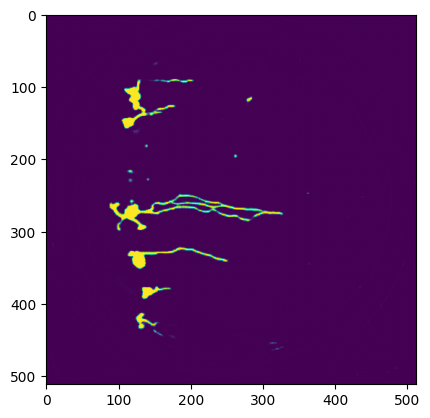

In [35]:
plt.imshow(outputs.cpu().permute(1,2,0).detach().numpy())

In [36]:
test = Test_dataset(val_aug,'crosval/test',device)

['AAE_0023.png', 'AAE_0074.png', 'AAE_0086.png', 'AAE_0138.png', 'AAE_0160.png', 'AAE_0172.png', 'AAE_0205.png', 'AAE_0221.png', 'AAE_0223.png', 'AAE_0237.png']


In [37]:
test_loader = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)

In [38]:
outputs
for inputs in tqdm(test_loader):
    model.eval()
    outputs = model(inputs)

100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


In [39]:
outputs.shape

torch.Size([10, 1, 512, 512])

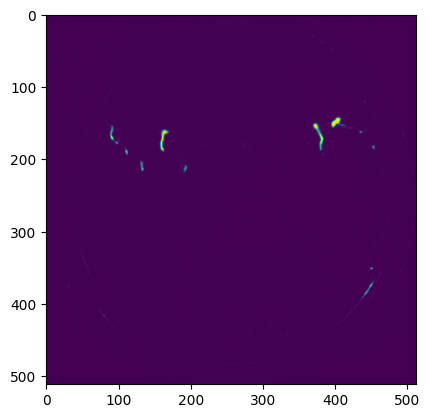

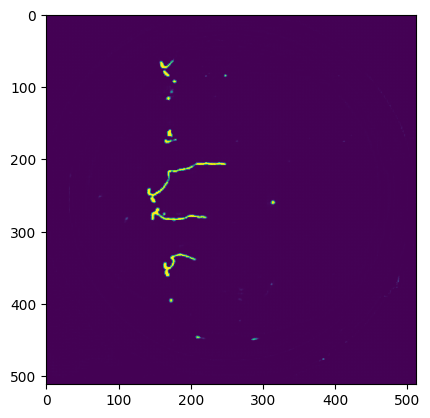

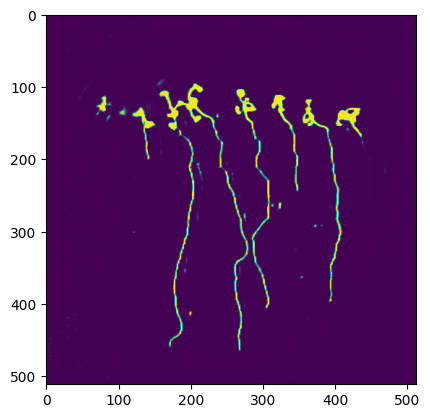

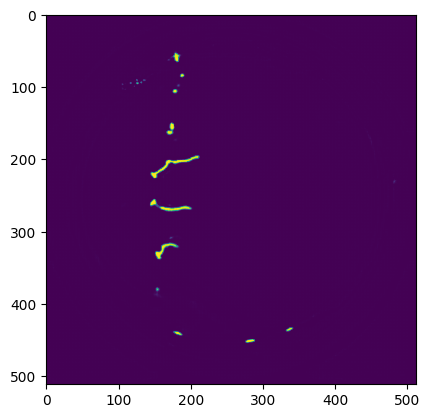

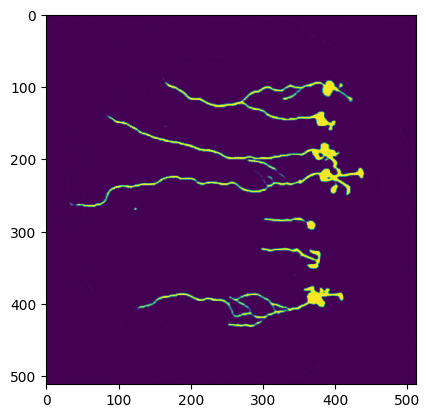

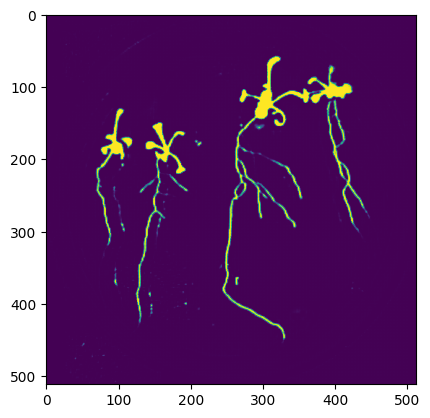

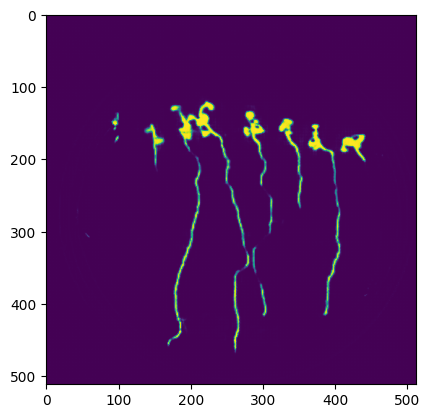

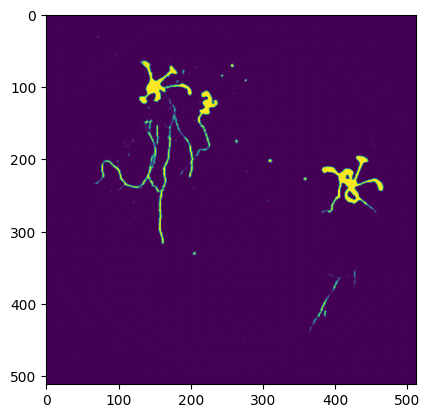

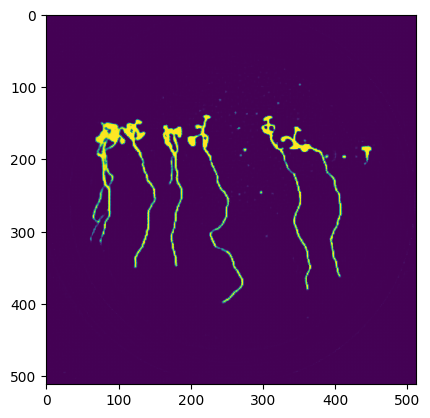

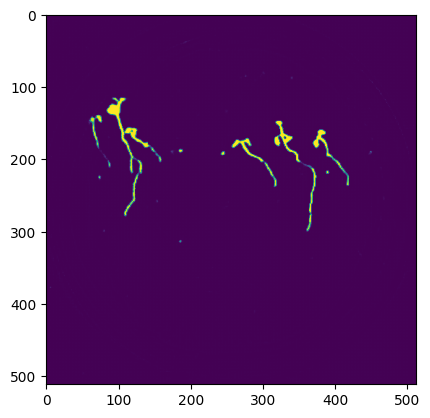

In [40]:
for i in outputs:
    i.reshape(1, 512, 512)
    plt.imshow(i.cpu().permute(1,2,0).detach().numpy())
    plt.pause(1)